## ***Загружаем данные, устанавливаем и имопртируем все нужные библиотеки***

In [ ]:
! pip install wikipedia
! pip install nltk
! pip install rake-nltk

!pip install beautifulsoup4
!pip install wiki-ru-wordnet

!pip install navec
!pip install pyspellchecker
!pip install pymorphy2

In [ ]:
# импорты для web-scraping по wikipedia
import wikipedia
import random
import tqdm
import nltk
import re
import string
import threading
import multiprocessing
import os
import shutil
from nltk.corpus import stopwords
# импорты для обучения
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
from keras.layers import LSTM, Bidirectional, BatchNormalization
from keras.layers import SpatialDropout1D, Flatten, Conv2D
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2, l1_l2
import keras
# импорты для web-scraping по остальным сайтам
from bs4 import BeautifulSoup
import requests
from re import sub
from decimal import Decimal
import io
from datetime import datetime
from lxml import html
# импорты для поиска гиперонимов
from wiki_ru_wordnet import WikiWordnet
# импорт для исправления опечаток
from spellchecker import SpellChecker
# импорт для приведения слов к начальной форме
import pymorphy2
from navec import Navec

In [ ]:
# пока не используем
nltk.download('stopwords') # слова, не несущие тематического смылса (предлоги, союзы и тп)
nltk.download('punkt') # слова, не несущие тематического смылса (знаки препинания)

In [ ]:
#загрузим тестовый датасет с задачами, тематку которых нужно определить
test = pd.read_csv("test.csv")

In [ ]:
test["task"][2] # посмотрели пример

In [ ]:
wikipedia.set_lang("ru") # нас интересуют только ресурсы на русском языке

In [ ]:
wikiwordnet = WikiWordnet() # подгружаем в память всю лексическую базу 

In [ ]:
def find_tags(link, topic_set):
  # делаем запрос и получаем по ссылке html-текст
  html_text = requests.get(link).text
  # используем парсер lxml
  soup = BeautifulSoup(html_text, 'lxml')
  # div с ссылками на страницы по темам и предыдущую, следующую страницу
  div_pages = soup.find('div', id = 'mw-pages')
  # находим div c заданным классом
  div_topic_set = div_pages.find_all('div', class_ = "mw-category-group")
  for div in div_topic_set:
    # находим ссылки
    topic_set_tags = div.find_all('a')
    for tag in topic_set_tags:
      # уберем пояснения в скобках у слов
      word = tag.text
      ind = word.find('(')
      if ind != -1:
        word = word[:ind-1]
      # забираем только текст ссылки
      topic_set.add(word.lower())
  try:
    '''если доступны обе страницы следующая и предыдущая'''
    part_link = div_pages.find('a', string='Следующая страница')['href']
    find_tags('https://ru.wikipedia.org' + part_link, topic_set)
  except:
    pass

In [ ]:
def find_tags_with_cat(link, topic_set):
  '''подкатегории добавляем тоже'''
  # делаем запрос и получаем по ссылке html-текст
  html_text = requests.get(link).text
  # используем парсер lxml
  soup = BeautifulSoup(html_text, 'lxml')
  # div с ссылками на страницы по темам и предыдущую, следующую страницу
  div_pages = soup.find('div', id = 'mw-pages')
  # находим div c заданным классом
  div_topic_set = soup.find_all('div', class_ = "mw-category-group")
  for div in div_topic_set:
    # находим ссылки
    topic_set_tags = div.find_all('a')
    for tag in topic_set_tags:
      # уберем пояснения в скобках у слов
      word = tag.text
      ind = word.find('(')
      if ind != -1:
        word = word[:ind-1]
      # забираем только текст ссылки
      topic_set.add(word.lower())
  try:
    '''если доступны обе страницы следующая и предыдущая'''
    part_link = div_pages.find('a', string='Следующая страница')['href']
    find_tags('https://ru.wikipedia.org' + part_link, topic_set)
  except:
    pass

In [ ]:
def add(synset, depth):
  '''функция собирает к каждому синсету гипонимы, а к каждому набопу  
  гипонимов ищет новыйй набоп гипонимов и тд'''
  if depth == 0:
    return set()
  result = set()
  for hyponym in wikiwordnet.get_hyponyms(synset):
    for w in hyponym.get_words():
      result.add(w.lemma().lower())
    result |= add(hyponym, depth-1)
  return result

In [ ]:
def find_hypernym(word):
  '''ищем гиперонимы для слова word'''
  synset = wikiwordnet.get_synsets(word)[0]
  result = set()
  for hypernym in wikiwordnet.get_hypernyms(synset):
    for w in hypernym.get_words():
      result.add(w.lemma().lower())
  return result

In [ ]:
# def add(synset, depth):
#   '''тот же add, только добавляются в сет слова, рассматриваемого синсета, 
#   а не гипонимы'''
#   if depth == 0:
#     return set()
#   result = set()
#   for hyponym in wikiwordnet.get_hyponyms(synset):
#     for w in synset.get_words():
#       result.add(w.lemma().lower())
#     result |= add(hyponym, depth-1)
#   return result

In [ ]:
def re_ru(link, topic_set):
  # делаем запрос и получаем по ссылке html-текст
  html_text = requests.get(link).text
  # используем парсер lxml
  soup = BeautifulSoup(html_text, 'lxml')
  a = soup.find_all('a', class_= 'word-link')
  for el in a:
    word = el.text
    topic_set.add(word.lower())

In [ ]:
def word_asso(link, topic_set):
  # делаем запрос и получаем по ссылке html-текст
  html_text = requests.get(link).text
  # используем парсер lxml
  soup = BeautifulSoup(html_text, 'lxml')
  li = soup.find_all('li')
  for el in li:
    if el.find('span'):
      word = el.find('span').text
      topic_set.add(word.lower())

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

# ***Собираем животных***

##WIKIPEDIA

In [ ]:
animals = set()
# ищем страницу по названию страницы и записываем его url
url = wikipedia.page("Категория:Животные по алфавиту").url
# находим слова на заданной странице
find_tags(url, animals)

In [ ]:
len(animals)

38415

In [ ]:
list(animals)[:50]

['рыбы-хирурги',
 'pseudoscolia',
 'перламутровка красивая',
 'chaetocnema cylindrica',
 'myrmetes',
 'eupatorus beccari',
 'scymnus subvillosus',
 'чёрный носорог',
 'щелкун рейттера',
 'райская мухоловка',
 'усач-плотник',
 'niphanda',
 'птеранодоны',
 'ужасный листолаз',
 'narcine insolita',
 'липарисы',
 'araragi',
 'кавказский скосарь',
 'leptanilla kunmingensis',
 'белолобая щурка',
 'суматранский лангур',
 'peplometus',
 'чехонь',
 'omphale acuminata',
 'цихлида-колибри',
 'centromyrmex',
 'wallaba',
 'mesolecanium mayteni',
 'cyrtonota moderata',
 'сулавесская сипуха',
 'южноамериканская кваква',
 'epyris breviclypeatus',
 'синаптозавры',
 'amathynetoides',
 'атлантический пагуар',
 'черноватый стахирис',
 'средиземноморский бычерыл',
 'щелкун точечно-полосатый',
 'cephalotini',
 'issus coleoptratus',
 'туркестанская рысь',
 'горалы',
 'атлантический менхэден',
 'сенегальский лев',
 'steleopteron deichmuelleri',
 'черношейные ибисы',
 'тратихтиобразные',
 'gymnothorax moringa',

In [ ]:
list(animals)[:2000:100] # глянем, что получилось

['рыбы-хирурги',
 'белобрюхая каламария',
 'anthribus scapularis',
 'топорики-аргиропелекусы',
 'белозубочьи',
 'скалистые гекконы',
 'аризонский аспид',
 'bibio',
 'stephanogaster',
 'саванный слон',
 'corioxenidae',
 'megalodacne heros',
 'epyris idaten',
 'neothlipsis',
 'meoneura amurensis',
 'голубянка аргали',
 'западноафриканская генетта',
 'канареечный вьюрок',
 'amegosiphon',
 'mantophasma subsolana']

##WIKIWORDNET


In [ ]:
wikiwordnet.get_synsets('животное') #теперь к слову животное ищем слова синонимы

In [ ]:
animals_synsets = wikiwordnet.get_synsets('животное') # проверяемся
for w in animals_synsets[0].get_words():
  print(w.lemma())

животное


Исследование: какой синсет лучше взять (с индекслом 1 или 0)? 

In [ ]:
# сет из поддерева гипонимов, выходящих из синсета "животных" с индексом 0
animals2 = add(animals_synsets[0], 11) 
# сет из поддерева гипонимов, выходящих из синсета "животных" с индексом 1
animals2_2 = add(animals_synsets[1], 12) 

In [ ]:
# что входит в animals2_2 и что не входит в animals2
list(animals2_2 - animals2) 

['крольчонок',
 'львёнок',
 'животное',
 'мышонок',
 'крошка',
 'ярка',
 'мотылёк',
 'ягнёнок',
 'найдёныш',
 'кенгурёнок',
 'козлёнок',
 'пасынок',
 'козлик',
 'китёнок',
 'крапивница',
 'младенец',
 'малыш',
 'новорождённый',
 'бабочка',
 'лобстер',
 'оленёнок',
 'уродина',
 'кольчатый шелкопряд',
 'белянка',
 'омар',
 'плод',
 'восьмилеток',
 'рысёнок',
 'пяденица',
 'щурок',
 'дитя',
 'филинёнок',
 'головастик',
 'беби',
 'монашка',
 'крысёныш',
 'малёк',
 'бархатка',
 'древесница',
 'бельчонок',
 'зверёнок',
 'сеголетка',
 'слонёнок',
 'кольчатый коконопряд',
 'лангуст',
 'брюквенница',
 'зайчонок',
 'черепашонок',
 'белёк',
 'октябрёнок',
 'гусёнок',
 'хорьчонок',
 'архарёнок',
 'грудник',
 'сын',
 'сайгачонок',
 'моль',
 'ребёнок',
 'малютка',
 'детёныш']

In [ ]:
# что входит в animals2 и что не входит в animals2_2
list(animals2 - animals2_2)

[]

Вывод: animals2_2 содержит больше данных

In [ ]:
 # замечаем, что в датасет попало слишком много слов относящихся к человеку
list(animals2_2)[:50]

['крольчонок',
 'колли',
 'совёнок',
 'рысь',
 'австралиец',
 'супердевушка',
 'крапивница',
 'брюхоногие',
 'чехонь',
 'щука',
 'кобелёк',
 'скотина',
 'каракатица',
 'слизняк',
 'фазан',
 'кожистая черепаха',
 'шалава',
 'токи',
 'паря',
 'кенарка',
 'алашанец',
 'амфисбена',
 'скат',
 'самбо',
 'конь',
 'протист',
 'развратница',
 'грязовик',
 'жёнка',
 'полоз',
 'дед',
 'поганка',
 'иглошерст',
 'пёсик',
 'дитя',
 'калифорниец',
 'агринец',
 'камбала',
 'луизианец',
 'пегий',
 'ящер',
 'овчарка',
 'бхопалец',
 'тахина',
 'вепрь',
 'телёнок',
 'аллахабадец',
 'гоминид',
 'бактриан',
 'свинья']

In [ ]:
# смотрим от каких слов могло произойти заданное слово и наличие в нашем сете, 
# чтобы понять от какого слова пошли ненужные нам слова
for hypernym in wikiwordnet.get_hypernyms(wikiwordnet.get_synsets('афганец')[0]):
  for w in hypernym.get_words():
    print(w.lemma(), w.lemma() in animals2)
  

борзая True


In [ ]:
def add_with_stop(synset, depth):
  '''добавим в нашу функцию сет "стоп-слов", 
  поддерево гипонимов которых не будет учитываться'''
  if depth == 0:
    return set()
  result = set()
  for hyponym in wikiwordnet.get_hyponyms(synset):
    stop_flag = False
    for w in hyponym.get_words():
      if w.lemma() in {'гоминид', 'гоминида'}: 
        stop_flag = True
      result.add(w.lemma())
    if not stop_flag:
      result |= add_with_stop(hyponym, depth-1)
  return result

можно подумать: "откуда там гоминиды?"
Ответ простой, мы в какой то момент получили слишком много слов, описывающих человека (мужчина, муж, тинейджер и тд). После прохода по гиперонимам этих слов выяснилось, что проблемы начинаются со слова гоминида. Ну мы и решили дальше их гипонимы не рассматривать. Ведь если саму глубину поиска ограничивать, то мы можем собрать не все слова. Плюс к сету стоп слов можно будет добавить потом что-то еще, если будет необходимость 

In [ ]:
# сет из поддерева гипонимов, выходящих из синсета "животных" 
# и учитывающий стоп-слова
animals2_with_stop_flag = add_with_stop(animals_synsets[1], 12)

In [ ]:
# смотрим какие слова отбросились из-за того, что мы ввели стоп-слова
list(animals2_2 - animals2_with_stop_flag)

['быстровец',
 'интердевочка',
 'мальчонка',
 'американец',
 'молокосос',
 'питекантроп',
 'щусёнок',
 'нью-йоркец',
 'пацан',
 'казах',
 'бангалурец',
 'беленец',
 'вандименец',
 'гей',
 'алигархец',
 'уйгур',
 'австралиец',
 'пупочка',
 'боготец',
 'фифа',
 'бхилаец',
 'супердевушка',
 'асадабадец',
 'велогонщица',
 'китаец',
 'лярва',
 'виньлинец',
 'колумбиец',
 'буэносайресец',
 'майорша',
 'индус',
 'рот',
 'блядь',
 'леди',
 'мальчик',
 'архатроп',
 'кореец',
 'франт',
 'аньдунец',
 'брабантка',
 'пацанёнок',
 'подкаблучник',
 'путана',
 'колош',
 'пенсионерка',
 'юнец',
 'аляскинец',
 'команч',
 'девица',
 'берлинка',
 'старец',
 'шалава',
 'тлинкит',
 'ацтек',
 'бхагалпурец',
 'мужик',
 'веллингтонец',
 'женщина лёгкого поведения',
 'фифочка',
 'мальчишка',
 'паря',
 'хозяйка',
 'чувак',
 'алашанец',
 'аргентинец',
 'самбо',
 'ирокез',
 'дядька',
 'кечуа',
 'афроамериканец',
 'немка',
 'барышня',
 'индиец',
 'бомбеец',
 'герой',
 'развратница',
 'малый',
 'едок',
 'висконсинец

In [ ]:
# добавим то, что выбросили, но нам подходит
animals2_with_stop_flag |= {"животное", "телец", "телёнок"}

In [ ]:
# уберем то, что нам не нужно
animals2_with_stop_flag -= {"шип"}

In [ ]:
print(len(list(animals2_with_stop_flag))) # проверяем длину и полученные слова на наличие лишних

729


In [ ]:
list(animals2_with_stop_flag)[:100] # проверим, какие слова входят

['крольчонок',
 'пустельга',
 'колли',
 'совёнок',
 'гиппурит',
 'рысь',
 'птенец',
 'крапивница',
 'брюхоногие',
 'апатозавр',
 'лемминг',
 'хряк',
 'чехонь',
 'щука',
 'кобелёк',
 'рысёнок',
 'скотина',
 'рептилия',
 'кукушонок',
 'кутёнок',
 'каракатица',
 'слизняк',
 'фазан',
 'кожистая черепаха',
 'гюрза',
 'колоконгер',
 'токи',
 'лигр',
 'кенарка',
 'амфисбена',
 'скат',
 'мартышка',
 'жаба',
 'конь',
 'енот',
 'якамара',
 'лаггар',
 'протист',
 'адский вампир',
 'орангутан',
 'грязовик',
 'сибиряк',
 'полоз',
 'поганка',
 'иглошерст',
 'младенец',
 'пёсик',
 'стафилококк',
 'спрут',
 'дитя',
 'летучая мышь',
 'камбала',
 'пегий',
 'ящер',
 'овчарка',
 'тахина',
 'кольчатый тюлень',
 'вепрь',
 'афганец',
 'телёнок',
 'гоминид',
 'бактриан',
 'свинья',
 'коккер',
 'иглянка',
 'тюлька',
 'продиноцерат',
 'хохотун',
 'кобылица',
 'коронавирус',
 'пудель',
 'тарантул',
 'гусёнок',
 'носуха',
 'обезьяна',
 'векша',
 'гусыня',
 'вертячка',
 'афалина',
 'ежонок',
 'коати',
 'тираннозав

##WORDASSOCIATION

In [ ]:
animals3 = set()
animals4 = set()
# животное
word_asso("https://wordassociation.ru/%D0%B6%D0%B8%D0%B2%D0%BE%D1%82%D0%BD%D0%BE%D0%B5", animals3)
# животные
word_asso("https://wordassociation.ru/%D0%B6%D0%B8%D0%B2%D0%BE%D1%82%D0%BD%D1%8B%D0%B5", animals4)
animals3 -= {"друг", "детёныш", "сущность", "ласка", "душа", "урок", "игра", "соседи"}
animals4 -= {"мир", "оригами", "егерь", "забота", "гон", "окружающее", "хозяйство", 
             "красивые", "люди", "хорошие", "мультфильмы", "шатёр", "хутор", 
             "расскраска", "энциклопедия", "село", "басня", "домашние", "большие", "остров", 
             "окружающее", "ответственность", "планета земля"}

In [ ]:
list(animals4)

['хищные',
 'сафари',
 'дом',
 'заповедник',
 'шерсть',
 'стая',
 'посёлок',
 'кот',
 'селекционер',
 'кошки',
 'джунгли',
 'клетки',
 'истребление',
 'скот',
 'блоха',
 'колхоз',
 'живность',
 'котята',
 'навоз',
 'наблюдение',
 'тропики',
 'обитание',
 'стайка',
 'питомец',
 'собаки',
 'парнокопытные',
 'пёс',
 'звуки животных',
 'корова',
 'зоопарк',
 'кошка',
 'зебра',
 'укротитель',
 'биология',
 'размножение',
 'дикие животные',
 'зоосад',
 'млекопитающие',
 'сарайчик',
 'экология',
 'фермер',
 'охотник',
 'цирк',
 'маленькие',
 'волк',
 'зоотехника',
 'лесная',
 'коты',
 'ареал',
 'деревенька',
 'перелесок',
 'млекопитающее',
 'доброта',
 'австралия',
 'лошадь',
 'окружающая среда',
 'корма',
 'живот',
 'хищники',
 'обезьяна',
 'природа',
 'опыты',
 'флора',
 'тропа',
 'африка',
 'животное',
 'хомяк',
 'дикие',
 'стадо',
 'медведь',
 'спячка',
 'лесок',
 'верблюды',
 'отбор',
 'стойбище',
 'нашествие',
 'курица',
 'маугли',
 'мышь',
 'раскраска',
 'собака',
 'особь',
 'сено',
 '

##RERIGHT.RU

In [ ]:
animals_re = set()
re_ru("http://www.reright.ru/analysis/349917~%D0%B6%D0%B8%D0%B2%D0%BE%D1%82%D0%BD%D0%BE%D0%B5.html", animals_re)

In [ ]:
list(animals_re)[:50]

['хищным',
 'разъяренным',
 'сделать',
 'дорога',
 'дом',
 'проклятым',
 'труд',
 'рог',
 'тупым',
 'священным',
 'сильным',
 'единственным',
 'бояться',
 'жертвенным',
 'вид',
 'раненым',
 'существовать',
 'течение',
 'скот',
 'издать',
 'планета',
 'раненным',
 'великолепным',
 'скотина',
 'представлять',
 'травоядным',
 'почувствовать',
 'название',
 'гигантским',
 'любить',
 'исчезнуть',
 'производить',
 'взвиться',
 'рвануться',
 'появиться',
 'казаться',
 'галоп',
 'прекрасным',
 'чувствовать',
 'являться',
 'стоять',
 'город',
 'понимать',
 'жвачным',
 'привязываться',
 'обладать',
 'зоопарк',
 'крупа',
 'чудовище',
 'небольшим']

##ОБЪЕДИНЕНИЕ 

In [ ]:
all_animals = (animals | animals2_with_stop_flag | animals3 | animals4) - {'коньки', 'парусник'}

In [ ]:
len(all_animals)

39191

# ***Собираем музыку***

##WIKIPEDIA

In [ ]:
music = set()
find_tags(wikipedia.page("Категория:Музыкальные_жанры").url, music)
music -= {"Список музыкальных жанров, направлений и стилей"}

In [ ]:
len(music)
list(music)[:50]

['цыганский романс',
 'буги',
 'славянский фолк',
 'пейсли-андеграунд',
 'хайфи',
 'минимализм',
 'мелодичный дэт-метал',
 'прогрессив-хаус',
 'экспериментальный поп',
 'рара',
 'k-pop',
 'госпел',
 'кай',
 'дамп',
 'электрик-блюз',
 'регги',
 'суомисаунди',
 'регги-рок',
 'дабстеп',
 'фобурдон',
 'математический рок',
 'индастриал-рок',
 'пачанга',
 'минимал-техно',
 'бростеп',
 'дэнсхолл',
 'мидивал-фолк-рок',
 'прото-прог',
 'ликвид-фанк',
 'хард-транс',
 'английская музыка',
 'американа',
 'электро-индастриал',
 'советвейв',
 'бангсаван',
 'психоделический фанк',
 'анатолийский рок',
 'бабблгам-поп',
 'adult contemporary',
 'брутальный дэт-метал',
 'трип-хоп',
 'народная музыка индейцев',
 'брейкстеп',
 'христианский рок',
 'моноопера',
 'хип-хоп восточного побережья',
 'азербайджанский рок',
 'комедийный хип-хоп',
 'спид-метал',
 'сибуя-кэй']

In [ ]:
music2 = set()
find_tags(wikipedia.page("Категория:Музыкальные термины").url, music2)
music2 -= {"Список музыкальных обозначений"}

In [ ]:
len(music2)

520

In [ ]:
music3 = set()
find_tags(wikipedia.page("Категория:Ритм").url, music3)
find_tags(wikipedia.page("Категория:Длительности").url, music3)
find_tags(wikipedia.page("Категория:Дирижирование").url, music3)
music3 -= {'Особые виды ритмического деления', 'Оркестр без дирижёра'}

In [ ]:
list(music3)

['аугментация',
 'баттута',
 'хейрономия',
 'анданте',
 'затакт',
 'ритм',
 'ритмическое деление',
 'дирижёрская палочка',
 'bpm',
 'бласт-бит',
 'аритмия',
 'изоритмия',
 'талам',
 'оркестр без дирижёра',
 'полиметрия',
 'концертмейстер',
 'гокет',
 'рубато',
 'метроном',
 'полиритмия',
 'особые виды ритмического деления',
 'капельмейстер',
 'диминуция',
 'дирижёр']

##WIKIWORDNET

In [ ]:
music4_1 = add(wikiwordnet.get_synsets('музыка')[0], 4)
music4_2 = add(wikiwordnet.get_synsets('музыка')[1], 2)
music4 = music4_1 | music4_2 | {'музыка'}

In [ ]:
list(music4)[:100]

['лейтмотив',
 'гимн',
 'глас',
 'глиссандо',
 'трель',
 'лениция',
 'рибоп',
 'мотив',
 'джаз',
 'мордент',
 'минусовка',
 'тема',
 'форшлаг',
 'минус',
 'придыхание',
 'напев',
 'катюша',
 'симфония',
 'фуга',
 'рулада',
 'мелодия',
 'музыка',
 'пение',
 'блюз',
 'аспирация',
 'апподжиатура',
 'мелизм']

In [ ]:
list(music4 - music4_2)

['лейтмотив',
 'гимн',
 'напев',
 'катюша',
 'музыка',
 'мелодия',
 'пение',
 'мотив',
 'тема']

##WORDASSOCIATION

In [ ]:
music5 = set()
word_asso("https://wordassociation.ru/%D0%BC%D1%83%D0%B7%D1%8B%D0%BA%D0%B0", music5)
music5 -= {"ключ", "любовь", "уши", "душа", "урок", "игра", "соседи"}

In [ ]:
list(music5)

['музыкальный',
 'скрипач',
 'октава',
 'ноты',
 'студия',
 'баян',
 'поп',
 'маэстро',
 'аккорд',
 'творчество',
 'громкость',
 'транзистор',
 'дудеть',
 'концерт',
 'оркестр',
 'квартет',
 'смычок',
 'играть',
 'хорал',
 'певица',
 'танец',
 'сольфеджио',
 'вокал',
 'блюз',
 'гимн',
 'композитор',
 'муза',
 'слушатель',
 'телефон',
 'хор',
 'бах',
 'твист',
 'балет',
 'рояль',
 'ми',
 'певец',
 'пластина',
 'человек-оркестр',
 'тверкинг',
 'песенка',
 'клавиши',
 'дисковод',
 'нотка',
 'балалайка',
 'менуэт',
 'винил',
 'артист',
 'динамик',
 'барабан',
 'музицировать',
 'соль',
 'преемник',
 'микрофон',
 'полька',
 'гопак',
 'трек',
 'симфония',
 'стили музыки',
 'танцоры',
 'сальса',
 'ностальгия',
 'струна',
 'инструмент',
 'радио',
 'музыкальный инструмент',
 'танцы',
 'нота',
 'динамика',
 'дискотеки',
 'исполнительница',
 'голос',
 'фламенко',
 'скрипичный',
 'стиль',
 'нирвана',
 'громкий',
 'колонки',
 'пляски',
 'стереотруба',
 'дудочка',
 'вечеринка',
 'самба',
 'рок',
 'га

##ОБЪЕДИНЕНИЕ

In [ ]:
all_music = (music | music2 | music3 | music4) - {'поэма', 'метр'}

In [ ]:
len(all_music)

1220

# ***Собираем спорт***

##WIKIPEDIA

In [ ]:
sport = set()
find_tags(wikipedia.page("Категория:Виды_спорта").url, sport)
find_tags_with_cat(wikipedia.page("Категория:Командные_виды_спорта").url, sport)
find_tags_with_cat(wikipedia.page("Категория:Индивидуальные_виды_спорта").url, sport)
find_tags_with_cat(wikipedia.page("Категория:Игровые_виды_спорта").url, sport)
sport -= {"Национальные виды спорта", "Неолимпийские виды спорта, признанные Международным олимпийским комитетом", "Вид спорта", "Командные виды спорта‎"}

In [ ]:
list(sport)[:50]

['киикинг',
 'скоростной съезд на воках',
 'tough mudder',
 'бадминтон',
 'хоккей',
 'вертолётный спорт',
 'шахбокс',
 'многоборья',
 'финский бейсбол',
 'лагори',
 'автоспорт',
 'аллейкэт',
 'поло',
 'вид спорта',
 'триал',
 'сепактакрау regu',
 'скелетон',
 'камоги',
 'кегельбан',
 'регбилиг',
 'софтбол',
 'ринкбол',
 'футбэг',
 'водное поло',
 'хоккей на траве',
 'родео',
 'сепактакрау',
 'торбол',
 'пляжный волейбол',
 'конькобежный спорт',
 'слэмбол',
 'сноуборд',
 'мини-футбол',
 'акватлон',
 'флэтбол',
 'горный велоспорт',
 'стрелковый спорт',
 'слэклайн',
 'кила',
 'австралийский футбол',
 'пляжный футбол',
 'верховая езда',
 'борьба',
 'универсальный бой',
 'биатлон',
 'английская лапта',
 'ironman',
 'мотобол',
 'фристайл на бурной воде',
 'регби-7']

##WIKIWORDNET

In [ ]:
sport2 = add(wikiwordnet.get_synsets('спорт')[0], 5) | {'спорт'}

In [ ]:
list(sport2)

['пинг-понг',
 'бадминтон',
 'волейбол',
 'физическая культура',
 'велогонка',
 'хоккей',
 'фитнес',
 'спортивная игра',
 'ручной мяч',
 'моторалли',
 'мотокросс',
 'баскетбол',
 'автогонки',
 'регби',
 'рыболовство',
 'пул',
 'американка',
 'ралли',
 'туризм',
 'автоспорт',
 'шахматы',
 'кёрлинг',
 'шашки',
 'настольный теннис',
 'крокет',
 'лёгкая атлетика',
 'гандбол',
 'бикса',
 'картинг',
 'физкультура',
 'биллиард',
 'бейсбол',
 'теннис',
 'гимнастика',
 'спорт',
 'автомарафон',
 'футбол',
 'шейпинг',
 'бильярд']

Нет ничего связанного с ролями в спорте

In [ ]:
sport3 = add(wikiwordnet.get_synsets('спортсмен')[0], 3) | {'спортсмен'} | add(wikiwordnet.get_synsets('тренироваться')[0], 3) | {'тренироваться'}

In [ ]:
list(sport3)

['бейсджампер',
 'борец',
 'центрфорвард',
 'эспадронист',
 'лучник',
 'кетчист',
 'саблист',
 'слаломист',
 'легионер',
 'атлет',
 'спринтер',
 'голкипер',
 'бадминтонист',
 'горнолыжник',
 'защитник',
 'велогонщица',
 'футболист',
 'заниматься йогой',
 'ракетка',
 'форвард',
 'многоборец',
 'каякер',
 'спортсмен',
 'дуатлонист',
 'тянуться',
 'трейсер',
 'нападающий',
 'качать пресс',
 'байдарочник',
 'пловец',
 'хавбек',
 'мешок',
 'бейсболист',
 'круизер',
 'триалист',
 'бейсер',
 'акробат',
 'автогонщик',
 'фехтовальщик',
 'бодибордер',
 'велосипедист',
 'канарейка',
 'полумарафонец',
 'велогонщик',
 'капитан',
 'бегун',
 'кетчер',
 'кикер',
 'копьеметатель',
 'ватерполист',
 'триатлонист',
 'тренироваться',
 'метатель',
 'велосипедистка',
 'бомбардир',
 'вратарь',
 'виндсёрфер',
 'триатлет',
 'теннисист',
 'лыжник',
 'бек',
 'биатлонист',
 'фигурист',
 'шоссейник',
 'парусник',
 'раллист',
 'каноист',
 'дуатлет',
 'полузащитник',
 'конькобежец',
 'боксёр',
 'питчер']

##WORDASSOCIATION

In [ ]:
sport4 = set()
word_asso("https://wordassociation.ru/%D1%81%D0%BF%D0%BE%D1%80%D1%82", sport4)
sport4.add("гиря")
sport4 -= {"сочи", "cочи 2014", "необычность", "гирька"}

In [ ]:
list(sport4)

['труд',
 'секция',
 'трицепсы',
 'альпинизм',
 'хоккей',
 'бегать',
 'чемпионат',
 'отжимания',
 'мышца',
 'тренажёр',
 'атлет',
 'планка',
 'финал',
 'лига',
 'нокаут',
 'травма',
 'спортивный',
 'мяч',
 'пионербол',
 'лыжи',
 'команда',
 'раздевалка',
 'поле',
 'гиря',
 'зарядка',
 'прыжки',
 'ракетка',
 'связки',
 'плавание',
 'брусья',
 'убегать',
 'трамплин',
 'бросок',
 'волейболист',
 'активный',
 'арбалет',
 'дух',
 'инструктор',
 'ничья',
 'гонки',
 'ходьба',
 'ролик',
 'тренировка',
 'тело',
 'мат',
 'упражнения',
 'пловец',
 'скалолазание',
 'растяжка',
 'рывок',
 'достижения',
 'энергия',
 'допинг',
 'самбо',
 'утренняя зарядка',
 'коньки',
 'тверкинг',
 'успех',
 'бега',
 'спортплощадка',
 'разбег',
 'олимпийские игры',
 'спортзал',
 'стадион',
 'тренер',
 'сёрфинг',
 'здоровье',
 'борьба',
 'победа',
 'биатлон',
 'зал',
 'прыжок',
 'нокдаун',
 'стартап',
 'занятие',
 'ворота',
 'соревнования',
 'баскетбол',
 'бокс',
 'сборная',
 'абонемент',
 'боль',
 'кроссовки',
 'дист

##ОБЪЕДИНЕНИЕ 

In [ ]:
all_sport = (sport | sport2 | sport3 | sport4) - {'канарейка', 'скорость', 'время', 'успех'} | {'легкоатлет'}

In [ ]:
len(all_sport)

433


# ***Собираем литературу***

##WIKIPEDIA

In [ ]:
lit = set()
find_tags(wikipedia.page("Категория:Литературные_жанры").url, lit)
find_tags_with_cat(wikipedia.page("Категория:Литературные_термины").url, lit)
# lit -= {"", "", "", "", "", "", "", "", "", ""}

In [ ]:
list(lit)[:50]

['бульварный роман',
 'хамрийят',
 'сюжет',
 'сага',
 'скандинавская прядь',
 'сясэй',
 'ауто',
 'альтернативная история',
 'очерк',
 'психологический триллер',
 'сумма',
 'эпизод',
 'криптоистория',
 'мактуб',
 'эпиникий',
 'путевой очерк',
 'exempla',
 'предисловие',
 'эпистолярный роман',
 'гимн',
 'жанры тайской классической литературы',
 'эллипс',
 'философский роман',
 'подростковая литература',
 'эротическая литература',
 'поэзия фларф',
 'ода',
 'дидактическая литература',
 'мениппея',
 'автобиография',
 'идиллия',
 'zombie strip',
 'роды литературы',
 'фрашка',
 'компендиум',
 'любовный роман',
 'мэшап',
 'импрессионизм',
 'сказ',
 'диатриба',
 'мелодрама',
 'эпитафия',
 'криминальный роман',
 'руритания',
 'тенденциозная литература',
 'тула',
 'панегирик',
 'литературное направление',
 'поучение',
 'биография']

##WIKIWORDNET

In [ ]:
lit2 = add(wikiwordnet.get_synsets('книга')[0], 3) | {'книга', 'литература'}
lit2 -= {"диван"}

In [ ]:
list(lit2)

['книга',
 'флорарий',
 'собрание сочинений',
 'библия',
 'танах',
 'фолиант',
 'брошюра',
 'энциклопедия',
 'бестиарий',
 'сборник',
 'справочник',
 'литература',
 'невиим']

In [ ]:
# смотрим от каких слов могло произойти заданное слово и наличие в нашем сете, 
# чтобы понять от какого слова пошли ненужные нам слова
for hypernym in wikiwordnet.get_hyponyms(wikiwordnet.get_synsets('чтение')[0]):
  for w in hypernym.get_words():
    print(w.lemma(), w.lemma() in lit2)

Wikiwordnet очень плохо работает с темой "литература" слова библиотека, книга и чтение вообще никак не связаны

##WORDASSOCIATION

In [ ]:
lit3 = set()
word_asso("https://wordassociation.ru/%D0%BB%D0%B8%D1%82%D0%B5%D1%80%D0%B0%D1%82%D1%83%D1%80%D0%B0", lit3)
lit3 -= {"бумага", "дети", "русская", "учёба", "занятие", "изучение", "учить", 
         "русский", "учебники", "учительница", "школьник", "уроки", "учиться", 
         "учение", "учитель", "учителя", "ученик", "экзамен", "университет", 
         "преподаватель", "художественная", "олимпиада", "блок"}

In [ ]:
list(lit3)

['класс',
 'перо',
 'семантика',
 'учебник',
 'творчество',
 'трактат',
 'пьеса',
 'написание',
 'гипербола',
 'стих',
 'эпизод',
 'война и мир',
 'лингвист',
 'высказывание',
 'выражение',
 'пушкин',
 'предисловие',
 'небылица',
 'рукопись',
 'языковед',
 'лермонтов',
 'хрестоматия',
 'язык',
 'цензор',
 'поэт',
 'библиотека',
 'писать',
 'переплёт',
 'история',
 'сравнение',
 'монография',
 'произведение',
 'лингвистика',
 'современная литература',
 'прозаик',
 'буквы',
 'биография',
 'лауреат',
 'герой',
 'литера',
 'летопись',
 'фраза',
 'предложения',
 'сатира',
 'введение',
 'рассказ',
 'афоризм',
 'книги',
 'азбука',
 'диктант',
 'параграф',
 'развязка',
 'достоевский',
 'страницы',
 'словесность',
 'комедия',
 'гоголь',
 'восклицание',
 'поговорка',
 'содержание',
 'пословица',
 'издательство',
 'повествование',
 'байка',
 'утопия',
 'возрождение',
 'отрывок',
 'читатель',
 'письмо',
 'преступление и наказание',
 'изложение',
 'перевод',
 'томик',
 'цитата',
 'слова',
 'рифмова

##ОБЪЕДИНЕНИЕ

In [ ]:
all_lit = (lit | lit2 | lit3) - {"гимн", 'школа', 'сумма', 'класс'}

In [ ]:
len(all_lit)

379

# ***Обучение***

In [ ]:
sa, sl, sm = all_sport & all_animals, all_sport & all_lit, all_sport & all_music
al, am, lm =  all_animals & all_lit, all_animals & all_music, all_lit & all_music

In [ ]:
all_sport -= (sa | sl | sm)
all_animals -= (sa | al | am)
all_lit -= (sl | al | lm)
all_music -= (sm | am | lm)

In [ ]:
with open('all_animals.txt', 'w', encoding='utf-8') as f:
  print(*all_animals, file=f, sep=',')

In [ ]:
with open('all_music.txt', 'w', encoding='utf-8') as f:
  print(*all_music, file=f, sep=',')

In [ ]:
with open('all_sport.txt', 'w', encoding='utf-8') as f:
  print(*all_sport, file=f, sep=',')

In [ ]:
with open('all_lit.txt', 'w', encoding='utf-8') as f:
  print(*all_lit, file=f, sep=',')

In [ ]:
allWords = (all_animals, all_music, all_sport, all_lit)
categories = ("животные", "музыка", "спорт", "литература")

In [ ]:
for category, topic_words in zip(categories, allWords):
  print(category, ":", len(topic_words), "слов")
  print(*topic_words, sep=", ")

животные : 39185 слов
рыбы-хирурги, pseudoscolia, перламутровка красивая, chaetocnema cylindrica, myrmetes, eupatorus beccari, scymnus subvillosus, чёрный носорог, щелкун рейттера, райская мухоловка, усач-плотник, niphanda, птеранодоны, ужасный листолаз, narcine insolita, липарисы, araragi, кавказский скосарь, leptanilla kunmingensis, белолобая щурка, суматранский лангур, peplometus, чехонь, omphale acuminata, цихлида-колибри, centromyrmex, wallaba, mesolecanium mayteni, cyrtonota moderata, сулавесская сипуха, южноамериканская кваква, epyris breviclypeatus, синаптозавры, amathynetoides, грызун, атлантический пагуар, черноватый стахирис, средиземноморский бычерыл, щелкун точечно-полосатый, cephalotini, issus coleoptratus, туркестанская рысь, горалы, атлантический менхэден, сенегальский лев, steleopteron deichmuelleri, черношейные ибисы, тратихтиобразные, gymnothorax moringa, точечная митра, almeidaia, tephritis, беличий кускус, бенгальская тидемания, тиморская мухоловка, чёрный кулик-со

## NAVEC  (работает с точностью 0.76)

In [ ]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

def cosine_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

In [ ]:
morph = pymorphy2.MorphAnalyzer()
russian = SpellChecker(language='ru')
punctuation = re.compile(r'[!()\-\[\]{};:\\,<>./?@#$%^&*_~—]')

stopWordsRu = set(stopwords.words("russian"))

def token_to_embed_id(word):
    # Игнорируем стоп слов + пунктуацию
    if word in stopWordsRu:
        return None

    # Если слово в словаре
    for category, topic_words in zip(categories, allWords):
      if word in topic_words:
        return navec.vocab[category]

    # Если слово имеет эмбеддинг
    if word in navec.vocab:
        return navec.vocab[word]

    return navec.vocab['<unk>']


def text_to_ids(text: str):
    tokens = []
    embed_ids = []
    for word in punctuation.sub(' ', text).split():
        word = russian.correction(word.strip().lower())
        
        p = morph.parse(word)[0]
        embed_id = token_to_embed_id(p.normal_form)

        if embed_id is not None:
            tokens.append(word)
            embed_ids.append(embed_id)
    return tokens, embed_ids

In [ ]:
from scipy.special import softmax

classes = [
           'животные',
           'спорт',
           'музыка',
           'литература'
]

classes_emb = [
               navec[class_name] for class_name in classes
]

def get_sentence_predictions(sentence: str):
    tokens, embed_ids = text_to_ids(sentence)
    embeddings = np.array([navec.pq[embed_id] for embed_id in embed_ids])
    mean_emb = embeddings.sum(axis=0)
    
    results =[
        np.dot(class_emb, mean_emb) for class_emb in classes_emb
    ]

    results = softmax(results)

    return results

def get_word_significancy(sentence: str, class_: int):
    tokens, embed_ids = text_to_ids(sentence)

    embeddings = np.array([navec.pq[embed_id] for embed_id in embed_ids])

    results = [
        (cosine_similarity(token_emb, classes_emb[class_]), token) for token, token_emb in zip(tokens, embeddings)
    ]
    return sorted(results, reverse=True)

In [ ]:
i = 100
#some_tasks = test["task"][i:i + 10]
task = test["task"][1]
#for task in some_tasks:
  #print(i)
preds = get_sentence_predictions(task)
word_significancy = get_word_significancy(task, np.argmax(preds))
print('-----------------')
print(task)
print('Предсказанный класс: ', classes[np.argmax(preds)])
print('Предсказанные вероятности: ', preds)
print(word_significancy)
print()
  #i += 1

-----------------
Реши задачу.
Сколько коробок корма для собак поместится в ящике, если все стороны ящика соответственно в 12 раз больше сторон коробки корма?
Предсказанный класс:  животные
Предсказанные вероятности:  [1.0000000e+00 2.8025969e-45 5.7564598e-33 2.4127787e-38]
[(0.99999994, 'собак'), (0.99999994, 'корма'), (0.99999994, 'корма'), (0.15688716, 'соответственно'), (0.13559328, 'все'), (0.09036985, 'больше'), (0.08726994, 'реши'), (0.08583778, 'сколько'), (0.052340176, 'задачу'), (0.007747753, 'коробок'), (0.007747753, 'коробки'), (0.0021962721, 'ящике'), (0.0021962721, 'ящика'), (-0.021025268, 'поместите'), (-0.042625256, 'стороны'), (-0.042625256, 'сторон'), (-0.23617359, '12')]



In [ ]:
submit = {}
a = len(test)
for i in range(a):
  task = test['task'][i]
  #print(task)
  preds = get_sentence_predictions(task)
  word_significancy = get_word_significancy(task, np.argmax(preds))
  keywords = set()
  j = 0
  while len(keywords) < 3:
    keywords.add(word_significancy[j])
    j += 1
  submit[i] = ((classes[np.argmax(preds)]), list(keywords))
  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
submit1 = {'id':[], 'category':[], 'keywords':[]}
for i in range(a):
  cat, keywords = submit[i][0], ';'.join([x[1] for x in submit[i][1]])
  submit1['id'] += [i]
  submit1['category'] += [cat]
  submit1['keywords'] += [keywords]
submit2 = pd.DataFrame(submit1)

## FASTTEXT with cosine_similarity  (работает с точностью 0.49)

In [ ]:
!pip install fasttext

In [ ]:
import fasttext
import fasttext.util as fu
from scipy.spatial.distance import cosine
from scipy.spatial.distance import cdist

fu.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

def cosine_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

In [ ]:
morph = pymorphy2.MorphAnalyzer()
russian = SpellChecker(language='ru')
punctuation = re.compile(r'[!()\-\[\]{};:\\,<>./?@#$%^&*_~—]')

stopWordsRu = set(stopwords.words("russian"))

def token_to_vector(word):
    # Игнорируем стоп слов + пунктуацию
    if word in stopWordsRu:
        return None

    # Если слово в словаре
    for category, topic_words in zip(categories, allWords):
      if word in topic_words:
        return ft.get_word_vector(category)

    return ft.get_word_vector(word)


def embeddings(text: str):
    tokens = []
    vecs = []
    for word in punctuation.sub(' ', text).split():
        word = russian.correction(word.strip().lower())
        
        p = morph.parse(word)[0]
        vec = token_to_vector(p.normal_form)

        if vec is not None:
            tokens.append(word)
            vecs.append(vec)
    return tokens, vecs

In [ ]:
from scipy.special import softmax

classes = [
           'животные',
           'спорт',
           'музыка',
           'литература'
]

classes_emb = [
  ft.get_word_vector(class_name) for class_name in classes
]

def get_sentence_predictions(sentence: str):
    tokens, embs = embeddings(sentence)
    mean_emb = np.array(embs).sum(axis=0)
    results =[
        np.dot(class_emb, mean_emb) for class_emb in classes_emb
    ]

    results = softmax(results)

    return results

def get_word_significancy(sentence: str, class_: int):
    tokens, embs = embeddings(sentence)

    results = [
        (cosine_similarity(token_emb, classes_emb[class_]), token) for token, token_emb in zip(tokens, embs)
    ]
    return sorted(results, reverse=True)

In [ ]:
submit = {}
a = len(test)
for i in range(a):
  task = test['task'][i]
  #print(task)
  preds = get_sentence_predictions(task)
  word_significancy = get_word_significancy(task, np.argmax(preds))
  keywords = set()
  j = 0
  while len(keywords) < 3:
    keywords.add(word_significancy[j])
    j += 1
  submit[i] = ((classes[np.argmax(preds)]), list(keywords))
  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
submit1 = {'id':[], 'category':[], 'keywords':[]}
for i in range(a):
  cat, keywords = submit[i][0], ';'.join([x[1] for x in submit[i][1]])
  submit1['id'] += [i]
  submit1['category'] += [cat]
  submit1['keywords'] += [keywords]
submit2 = pd.DataFrame(submit1)

## FASTTEXT with cosine  (работает с точностью 0.57)

In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 2.1 MB/s 
  Using cached pybind11-2.8.0-py2.py3-none-any.whl (207 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3124780 sha256=415a18ea83bebce99bbc7f7076bbd2419196f05987babe8ff5dd8cc88e966428
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import fasttext
import fasttext.util as fu
from scipy.spatial.distance import cosine
from scipy.spatial.distance import cdist

fu.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')


In [ ]:
morph = pymorphy2.MorphAnalyzer()
russian = SpellChecker(language='ru')
punctuation = re.compile(r'[!()\-\[\]{};:\\,<>./?@#$%^&*_~—]')

stopWordsRu = set(stopwords.words("russian"))

def token_to_vector(word):
    # Игнорируем стоп слов + пунктуацию
    if word in stopWordsRu:
        return None

    # Если слово в словаре
    for category, topic_words in zip(categories, allWords):
      if word in topic_words:
        return ft.get_word_vector(category)

    return ft.get_word_vector(word)


def embeddings(text: str):
    tokens = []
    vecs = []
    for word in punctuation.sub(' ', text).split():
        word = russian.correction(word.strip().lower())
        
        p = morph.parse(word)[0]
        vec = token_to_vector(p.normal_form)

        if vec is not None:
            tokens.append(word)
            vecs.append(vec)
    return tokens, vecs

In [ ]:
from scipy.special import softmax

classes = [
           'животные',
           'спорт',
           'музыка',
           'литература'
]

classes_emb = [
  ft.get_word_vector(class_name) for class_name in classes
]

def get_word_significancy(sentence: str, class_: int):
    tokens, embs = np.array(embeddings(sentence))
    results = [
        (1-cosine(token_emb, classes_emb[class_]), token) for token, token_emb in zip(tokens, embs)
    ]
    for token, token_emb in zip(tokens, embs):
      results(1-cosine(token_emb, classes_emb[class_]), token))
    return sorted(results, reverse=True)

In [ ]:
i = 150
def get_pred_and_keywords(i: int):
  task = test["task"][i]
  preds = []
  keywords = {}
  word_significancy = {}
  for i in range(4):
    class_ = classes[i]
    word_significancy[class_] = get_word_significancy(task, i)
    keywords[i] = set()
    mean_keyword_emb = np.zeros(len(classes_emb[i]))
    j = 0
    while len(keywords[i]) < 3:
      keywords[i].add(word_significancy[class_][j][1])
      mean_keyword_emb += ft.get_word_vector(word_significancy[class_][j][1])
      j += 1
    preds += [np.dot(classes_emb[i], mean_keyword_emb)]
  return classes[np.argmax(preds)], list(keywords[np.argmax(preds)])

In [ ]:
submit = {}
a = len(test)
for i in range(a):
  submit[i] = get_pred_and_keywords(i)
  print(i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [ ]:
submit1 = {'id':[], 'category':[], 'keywords':[]}
for i in range(a):
  cat, keywords = submit[i][0], ';'.join([x[1] for x in submit[i][1]])
  submit1['id'] += [i]
  submit1['category'] += [cat]
  submit1['keywords'] += [keywords]
submit2 = pd.DataFrame(submit1)

# ***Сабмит решения***


In [ ]:
submit2.to_csv('submission.csv')

# ***Черновик какой-то***

Плохо работает, вопросы(индексы):8,12?, 14?,19!!,22!!!! 29, 35,41,42,45,47,50,51,54?,56,57,60,66,67,73, 74,83,84,85,87,90,94,97,99,100,105,109,,,,

In [ ]:
'судак' in all_animals

True

In [ ]:
'время' in all_lit

False

'электросамокат' надо бы в спорт (13 i)

класс, сказанное, м,ученик???,, - не литература

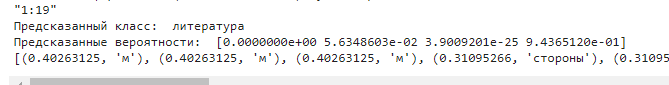

In [ ]:
('спортсмен' or 'гребец' or 'пловец' or 'бассейн' or 'ролики' or 'велосипед') in all_sport

True

In [ ]:
'успех' in all_sport

False

In [ ]:
('легкоатлет' or 'финишировать' or 'соревнование') in all_sport

True

легкая атлетика, танцы, бальные танцы, теннисный корт, волейбол, волейбольная сетка, наколенники, байдарка,бегун, плот(справлялся), тренер, сплав (по реке) - все в спорт

In [ ]:
'время' in all_sport

False

In [ ]:
'индюшка' in all_animals

False

лошадь, рыбка,зоомагазин,парнокопытные,пресмыкающиеся,поросенок,лапа,воробей,,,,,,,,,.. - животные

!!!друг - это не животное

!!секунда, метр, см, комната- это не музыка

нота, частота (в каких то случаях) - музыка